# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed",
    "device": "cuda",
    "lr": 0.0001,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_power"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_power"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run2_",
        },
    ],
    "dataset_seed": 7,
    "seed": 7,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run1_44', 'ORACLE.run1_20', 'ORACLE.run1_32', 'ORACLE.run1_50', 'ORACLE.run1_38', 'ORACLE.run1_8', 'ORACLE.run1_26', 'ORACLE.run1_14'}


{'ORACLE.run2_50', 'ORACLE.run2_38', 'ORACLE.run2_14', 'ORACLE.run2_20', 'ORACLE.run2_8', 'ORACLE.run2_26', 'ORACLE.run2_44', 'ORACLE.run2_32'}


tensor([[[ 0.8613,  0.6522, -0.8613,  ..., -0.7191,  0.0084, -1.1790],
         [-0.5435,  0.4264,  0.8863,  ..., -0.7358, -1.3044, -0.0334]],

        [[ 0.4337,  1.0374, -0.6973,  ..., -0.7568,  0.8758, -0.0255],
         [-0.3656,  0.6207,  0.3316,  ..., -0.5017, -0.9779, -0.9354]],

        [[-0.3375, -0.6666,  0.8438,  ...,  0.7172, -1.0548, -0.3628],
         [ 0.2531, -0.9029, -0.1856,  ...,  0.7594,  0.6835,  0.7848]],

        ...,

        [[-0.4226, -0.9694,  0.4143,  ...,  0.9694,  0.4060,  1.0771],
         [ 1.0026,  0.0663, -1.1517,  ...,  0.0580,  1.2014, -0.2651]],

        [[ 0.5145,  0.0083, -0.7385,  ..., -0.0747,  1.2446,  0.7551],
         [ 0.0000,  1.1119, -0.4149,  ..., -0.8795,  0.1494, -0.5808]],

        [[ 0.9155,  0.4773, -0.9859,  ..., -0.6495,  0.0078, -1.3146],
         [-0.5164,  0.4930,  0.7355,  ..., -0.8060, -1.1502,  0.1252]]])


In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 6720], examples_per_second: 33.0368, train_label_loss: 3.1050, 


epoch: 1, [batch: 672 / 6720], examples_per_second: 4537.6911, train_label_loss: 1.5277, 


epoch: 1, [batch: 1344 / 6720], examples_per_second: 4864.4390, train_label_loss: 0.7470, 


epoch: 1, [batch: 2016 / 6720], examples_per_second: 4891.5248, train_label_loss: 0.7994, 


epoch: 1, [batch: 2688 / 6720], examples_per_second: 4992.6789, train_label_loss: 0.6936, 


epoch: 1, [batch: 3360 / 6720], examples_per_second: 5098.9990, train_label_loss: 0.4978, 


epoch: 1, [batch: 4032 / 6720], examples_per_second: 5168.2491, train_label_loss: 0.7208, 


epoch: 1, [batch: 4704 / 6720], examples_per_second: 4831.1243, train_label_loss: 0.5575, 


epoch: 1, [batch: 5376 / 6720], examples_per_second: 5123.6066, train_label_loss: 0.9458, 


epoch: 1, [batch: 6048 / 6720], examples_per_second: 3998.2062, train_label_loss: 0.4591, 


epoch: 1, source_val_acc_label: 0.7646, target_val_acc_label: 0.7481, source_val_label_loss: 7.3736, target_val_label_loss: 10.7537, 


New best


epoch: 2, [batch: 1 / 6720], examples_per_second: 3.8879, train_label_loss: 0.8920, 


epoch: 2, [batch: 672 / 6720], examples_per_second: 3705.1126, train_label_loss: 0.8884, 


epoch: 2, [batch: 1344 / 6720], examples_per_second: 3852.6256, train_label_loss: 0.7650, 


epoch: 2, [batch: 2016 / 6720], examples_per_second: 3925.0293, train_label_loss: 0.3636, 


epoch: 2, [batch: 2688 / 6720], examples_per_second: 3948.8178, train_label_loss: 0.7663, 


epoch: 2, [batch: 3360 / 6720], examples_per_second: 3304.4880, train_label_loss: 0.4928, 


epoch: 2, [batch: 4032 / 6720], examples_per_second: 3375.2749, train_label_loss: 0.2621, 


epoch: 2, [batch: 4704 / 6720], examples_per_second: 3471.8644, train_label_loss: 0.4555, 


epoch: 2, [batch: 5376 / 6720], examples_per_second: 3352.2794, train_label_loss: 0.0987, 


epoch: 2, [batch: 6048 / 6720], examples_per_second: 3402.6722, train_label_loss: 0.5000, 


epoch: 2, source_val_acc_label: 0.8206, target_val_acc_label: 0.8054, source_val_label_loss: 0.4962, target_val_label_loss: 0.6423, 


New best


epoch: 3, [batch: 1 / 6720], examples_per_second: 3.2952, train_label_loss: 0.1139, 


epoch: 3, [batch: 672 / 6720], examples_per_second: 3034.9167, train_label_loss: 0.4876, 


epoch: 3, [batch: 1344 / 6720], examples_per_second: 3034.4555, train_label_loss: 0.1805, 


epoch: 3, [batch: 2016 / 6720], examples_per_second: 2994.3376, train_label_loss: 0.5671, 


epoch: 3, [batch: 2688 / 6720], examples_per_second: 2932.0632, train_label_loss: 0.4447, 


epoch: 3, [batch: 3360 / 6720], examples_per_second: 2959.5313, train_label_loss: 0.5799, 


epoch: 3, [batch: 4032 / 6720], examples_per_second: 2952.8736, train_label_loss: 0.3489, 


epoch: 3, [batch: 4704 / 6720], examples_per_second: 2975.5307, train_label_loss: 0.2814, 


epoch: 3, [batch: 5376 / 6720], examples_per_second: 2977.7095, train_label_loss: 0.5323, 


epoch: 3, [batch: 6048 / 6720], examples_per_second: 3018.4766, train_label_loss: 0.4794, 


epoch: 3, source_val_acc_label: 0.8446, target_val_acc_label: 0.8296, source_val_label_loss: 0.4325, target_val_label_loss: 0.6566, 


New best


epoch: 4, [batch: 1 / 6720], examples_per_second: 3.1367, train_label_loss: 0.3977, 


epoch: 4, [batch: 672 / 6720], examples_per_second: 3383.7231, train_label_loss: 0.1709, 


epoch: 4, [batch: 1344 / 6720], examples_per_second: 3347.9296, train_label_loss: 0.5366, 


epoch: 4, [batch: 2016 / 6720], examples_per_second: 3515.6611, train_label_loss: 0.3582, 


epoch: 4, [batch: 2688 / 6720], examples_per_second: 3126.9875, train_label_loss: 0.2229, 


epoch: 4, [batch: 3360 / 6720], examples_per_second: 2951.8871, train_label_loss: 0.3152, 


epoch: 4, [batch: 4032 / 6720], examples_per_second: 2934.2659, train_label_loss: 0.1392, 


epoch: 4, [batch: 4704 / 6720], examples_per_second: 2939.5506, train_label_loss: 0.7958, 


epoch: 4, [batch: 5376 / 6720], examples_per_second: 2912.1243, train_label_loss: 0.1374, 


epoch: 4, [batch: 6048 / 6720], examples_per_second: 2926.5280, train_label_loss: 0.2004, 


epoch: 4, source_val_acc_label: 0.8778, target_val_acc_label: 0.8644, source_val_label_loss: 0.3381, target_val_label_loss: 0.6201, 


New best


epoch: 5, [batch: 1 / 6720], examples_per_second: 2.7369, train_label_loss: 0.6681, 


epoch: 5, [batch: 672 / 6720], examples_per_second: 3370.1573, train_label_loss: 0.3071, 


epoch: 5, [batch: 1344 / 6720], examples_per_second: 3337.8375, train_label_loss: 0.2888, 


epoch: 5, [batch: 2016 / 6720], examples_per_second: 3391.2885, train_label_loss: 0.2177, 


epoch: 5, [batch: 2688 / 6720], examples_per_second: 3313.8061, train_label_loss: 0.1591, 


epoch: 5, [batch: 3360 / 6720], examples_per_second: 3334.7243, train_label_loss: 0.4246, 


epoch: 5, [batch: 4032 / 6720], examples_per_second: 3374.0708, train_label_loss: 0.3289, 


epoch: 5, [batch: 4704 / 6720], examples_per_second: 3424.2041, train_label_loss: 0.2481, 


epoch: 5, [batch: 5376 / 6720], examples_per_second: 2949.1428, train_label_loss: 0.1643, 


epoch: 5, [batch: 6048 / 6720], examples_per_second: 2948.0483, train_label_loss: 0.0763, 


epoch: 5, source_val_acc_label: 0.8834, target_val_acc_label: 0.8666, source_val_label_loss: 0.3353, target_val_label_loss: 0.6798, 


New best


epoch: 6, [batch: 1 / 6720], examples_per_second: 2.7302, train_label_loss: 0.2102, 


epoch: 6, [batch: 672 / 6720], examples_per_second: 2944.7333, train_label_loss: 0.3779, 


epoch: 6, [batch: 1344 / 6720], examples_per_second: 2963.4559, train_label_loss: 0.1516, 


epoch: 6, [batch: 2016 / 6720], examples_per_second: 2923.3633, train_label_loss: 0.3059, 


epoch: 6, [batch: 2688 / 6720], examples_per_second: 3205.5433, train_label_loss: 0.0208, 


epoch: 6, [batch: 3360 / 6720], examples_per_second: 3488.0505, train_label_loss: 0.3127, 


epoch: 6, [batch: 4032 / 6720], examples_per_second: 3757.2010, train_label_loss: 0.1181, 


epoch: 6, [batch: 4704 / 6720], examples_per_second: 3672.3198, train_label_loss: 0.1907, 


epoch: 6, [batch: 5376 / 6720], examples_per_second: 3690.4528, train_label_loss: 0.3010, 


epoch: 6, [batch: 6048 / 6720], examples_per_second: 3740.7682, train_label_loss: 0.2537, 


epoch: 6, source_val_acc_label: 0.8759, target_val_acc_label: 0.8551, source_val_label_loss: 0.3459, target_val_label_loss: 0.7339, 


epoch: 7, [batch: 1 / 6720], examples_per_second: 3.7992, train_label_loss: 0.0416, 


epoch: 7, [batch: 672 / 6720], examples_per_second: 3335.5575, train_label_loss: 0.2025, 


epoch: 7, [batch: 1344 / 6720], examples_per_second: 3007.1372, train_label_loss: 0.5715, 


epoch: 7, [batch: 2016 / 6720], examples_per_second: 2972.2369, train_label_loss: 0.2227, 


epoch: 7, [batch: 2688 / 6720], examples_per_second: 2957.6287, train_label_loss: 0.0217, 


epoch: 7, [batch: 3360 / 6720], examples_per_second: 2990.0182, train_label_loss: 0.4004, 


epoch: 7, [batch: 4032 / 6720], examples_per_second: 2998.8962, train_label_loss: 0.1959, 


epoch: 7, [batch: 4704 / 6720], examples_per_second: 2973.9994, train_label_loss: 0.2958, 


epoch: 7, [batch: 5376 / 6720], examples_per_second: 3233.1213, train_label_loss: 0.3797, 


epoch: 7, [batch: 6048 / 6720], examples_per_second: 3383.3696, train_label_loss: 0.2697, 


epoch: 7, source_val_acc_label: 0.8919, target_val_acc_label: 0.8730, source_val_label_loss: 0.3018, target_val_label_loss: 0.7768, 


New best


epoch: 8, [batch: 1 / 6720], examples_per_second: 3.0949, train_label_loss: 0.1681, 


epoch: 8, [batch: 672 / 6720], examples_per_second: 3552.2196, train_label_loss: 0.2074, 


epoch: 8, [batch: 1344 / 6720], examples_per_second: 3192.0503, train_label_loss: 0.1902, 


epoch: 8, [batch: 2016 / 6720], examples_per_second: 3005.5919, train_label_loss: 0.7268, 


epoch: 8, [batch: 2688 / 6720], examples_per_second: 2974.1302, train_label_loss: 0.5914, 


epoch: 8, [batch: 3360 / 6720], examples_per_second: 2982.9944, train_label_loss: 0.1839, 


epoch: 8, [batch: 4032 / 6720], examples_per_second: 2945.5188, train_label_loss: 0.1689, 


epoch: 8, [batch: 4704 / 6720], examples_per_second: 2940.7232, train_label_loss: 0.1512, 


epoch: 8, [batch: 5376 / 6720], examples_per_second: 2988.1505, train_label_loss: 0.1870, 


epoch: 8, [batch: 6048 / 6720], examples_per_second: 3034.4827, train_label_loss: 0.6729, 


epoch: 8, source_val_acc_label: 0.8950, target_val_acc_label: 0.8744, source_val_label_loss: 0.2968, target_val_label_loss: 0.8419, 


New best


epoch: 9, [batch: 1 / 6720], examples_per_second: 2.9678, train_label_loss: 0.0756, 


epoch: 9, [batch: 672 / 6720], examples_per_second: 3386.7912, train_label_loss: 0.1825, 


epoch: 9, [batch: 1344 / 6720], examples_per_second: 3495.5725, train_label_loss: 0.1275, 


epoch: 9, [batch: 2016 / 6720], examples_per_second: 3483.4725, train_label_loss: 0.1822, 


epoch: 9, [batch: 2688 / 6720], examples_per_second: 3362.2337, train_label_loss: 0.2110, 


epoch: 9, [batch: 3360 / 6720], examples_per_second: 3569.7665, train_label_loss: 0.1083, 


epoch: 9, [batch: 4032 / 6720], examples_per_second: 2923.4988, train_label_loss: 0.1523, 


epoch: 9, [batch: 4704 / 6720], examples_per_second: 2957.4408, train_label_loss: 0.0097, 


epoch: 9, [batch: 5376 / 6720], examples_per_second: 2993.4022, train_label_loss: 0.1999, 


epoch: 9, [batch: 6048 / 6720], examples_per_second: 3035.0271, train_label_loss: 0.3300, 


epoch: 9, source_val_acc_label: 0.9042, target_val_acc_label: 0.8805, source_val_label_loss: 0.2804, target_val_label_loss: 1.0104, 


New best


epoch: 10, [batch: 1 / 6720], examples_per_second: 2.7520, train_label_loss: 0.1932, 


epoch: 10, [batch: 672 / 6720], examples_per_second: 2916.7863, train_label_loss: 0.8523, 


epoch: 10, [batch: 1344 / 6720], examples_per_second: 3110.2430, train_label_loss: 0.1766, 


epoch: 10, [batch: 2016 / 6720], examples_per_second: 3356.0993, train_label_loss: 0.2219, 


epoch: 10, [batch: 2688 / 6720], examples_per_second: 3298.8525, train_label_loss: 0.3142, 


epoch: 10, [batch: 3360 / 6720], examples_per_second: 3450.0006, train_label_loss: 0.1161, 


epoch: 10, [batch: 4032 / 6720], examples_per_second: 3413.6287, train_label_loss: 0.3548, 


epoch: 10, [batch: 4704 / 6720], examples_per_second: 3361.7419, train_label_loss: 0.0946, 


epoch: 10, [batch: 5376 / 6720], examples_per_second: 3456.4049, train_label_loss: 0.1665, 


epoch: 10, [batch: 6048 / 6720], examples_per_second: 3459.8635, train_label_loss: 0.0434, 


epoch: 10, source_val_acc_label: 0.8981, target_val_acc_label: 0.8731, source_val_label_loss: 0.3143, target_val_label_loss: 1.0475, 


epoch: 11, [batch: 1 / 6720], examples_per_second: 3.1362, train_label_loss: 0.1735, 


epoch: 11, [batch: 672 / 6720], examples_per_second: 3579.0496, train_label_loss: 0.0729, 


epoch: 11, [batch: 1344 / 6720], examples_per_second: 3909.0426, train_label_loss: 0.6327, 


epoch: 11, [batch: 2016 / 6720], examples_per_second: 3739.9300, train_label_loss: 0.0566, 


epoch: 11, [batch: 2688 / 6720], examples_per_second: 3696.6976, train_label_loss: 0.2208, 


epoch: 11, [batch: 3360 / 6720], examples_per_second: 3711.8343, train_label_loss: 0.0469, 


epoch: 11, [batch: 4032 / 6720], examples_per_second: 3954.9415, train_label_loss: 0.5407, 


epoch: 11, [batch: 4704 / 6720], examples_per_second: 3959.4003, train_label_loss: 0.2561, 


epoch: 11, [batch: 5376 / 6720], examples_per_second: 4679.6234, train_label_loss: 0.0368, 


epoch: 11, [batch: 6048 / 6720], examples_per_second: 3973.3367, train_label_loss: 0.1397, 


epoch: 11, source_val_acc_label: 0.9027, target_val_acc_label: 0.8754, source_val_label_loss: 0.3338, target_val_label_loss: 1.1484, 


epoch: 12, [batch: 1 / 6720], examples_per_second: 3.1533, train_label_loss: 0.1066, 


epoch: 12, [batch: 672 / 6720], examples_per_second: 3358.1002, train_label_loss: 0.0390, 


epoch: 12, [batch: 1344 / 6720], examples_per_second: 3323.2391, train_label_loss: 0.2582, 


epoch: 12, [batch: 2016 / 6720], examples_per_second: 3423.9541, train_label_loss: 0.0260, 


epoch: 12, [batch: 2688 / 6720], examples_per_second: 3373.1782, train_label_loss: 0.1239, 


epoch: 12, [batch: 3360 / 6720], examples_per_second: 3382.1617, train_label_loss: 0.0404, 


epoch: 12, [batch: 4032 / 6720], examples_per_second: 3441.6597, train_label_loss: 0.2511, 


epoch: 12, [batch: 4704 / 6720], examples_per_second: 3599.0065, train_label_loss: 0.1946, 


epoch: 12, [batch: 5376 / 6720], examples_per_second: 3837.8267, train_label_loss: 0.1699, 


epoch: 12, [batch: 6048 / 6720], examples_per_second: 3922.9484, train_label_loss: 0.1180, 


epoch: 12, source_val_acc_label: 0.9057, target_val_acc_label: 0.8808, source_val_label_loss: 0.3268, target_val_label_loss: 1.2659, 


New best


epoch: 13, [batch: 1 / 6720], examples_per_second: 3.9197, train_label_loss: 0.2448, 


epoch: 13, [batch: 672 / 6720], examples_per_second: 3927.4521, train_label_loss: 0.0873, 


epoch: 13, [batch: 1344 / 6720], examples_per_second: 4030.6778, train_label_loss: 0.0657, 


epoch: 13, [batch: 2016 / 6720], examples_per_second: 3851.0446, train_label_loss: 0.0702, 


epoch: 13, [batch: 2688 / 6720], examples_per_second: 3754.9304, train_label_loss: 0.2617, 


epoch: 13, [batch: 3360 / 6720], examples_per_second: 3872.5808, train_label_loss: 0.1899, 


epoch: 13, [batch: 4032 / 6720], examples_per_second: 3980.2900, train_label_loss: 0.5664, 


epoch: 13, [batch: 4704 / 6720], examples_per_second: 3986.0513, train_label_loss: 0.1690, 


epoch: 13, [batch: 5376 / 6720], examples_per_second: 3989.9645, train_label_loss: 0.3798, 


epoch: 13, [batch: 6048 / 6720], examples_per_second: 3921.2766, train_label_loss: 0.2405, 


epoch: 13, source_val_acc_label: 0.8986, target_val_acc_label: 0.8701, source_val_label_loss: 0.3224, target_val_label_loss: 1.2688, 


epoch: 14, [batch: 1 / 6720], examples_per_second: 3.8633, train_label_loss: 0.0539, 


epoch: 14, [batch: 672 / 6720], examples_per_second: 3906.5228, train_label_loss: 0.2107, 


epoch: 14, [batch: 1344 / 6720], examples_per_second: 3982.0012, train_label_loss: 0.2337, 


epoch: 14, [batch: 2016 / 6720], examples_per_second: 3905.8712, train_label_loss: 0.0400, 


epoch: 14, [batch: 2688 / 6720], examples_per_second: 3876.6430, train_label_loss: 0.2339, 


epoch: 14, [batch: 3360 / 6720], examples_per_second: 3869.1444, train_label_loss: 0.1811, 


epoch: 14, [batch: 4032 / 6720], examples_per_second: 3779.7674, train_label_loss: 0.0452, 


epoch: 14, [batch: 4704 / 6720], examples_per_second: 3814.2565, train_label_loss: 0.2085, 


epoch: 14, [batch: 5376 / 6720], examples_per_second: 3788.3110, train_label_loss: 0.1361, 


epoch: 14, [batch: 6048 / 6720], examples_per_second: 3778.0424, train_label_loss: 0.0473, 


epoch: 14, source_val_acc_label: 0.9034, target_val_acc_label: 0.8743, source_val_label_loss: 0.3407, target_val_label_loss: 1.3132, 


epoch: 15, [batch: 1 / 6720], examples_per_second: 3.8158, train_label_loss: 0.2057, 


epoch: 15, [batch: 672 / 6720], examples_per_second: 3886.1557, train_label_loss: 0.1456, 


epoch: 15, [batch: 1344 / 6720], examples_per_second: 3954.3638, train_label_loss: 0.1683, 


epoch: 15, [batch: 2016 / 6720], examples_per_second: 3270.0297, train_label_loss: 0.3604, 


epoch: 15, [batch: 2688 / 6720], examples_per_second: 2968.7129, train_label_loss: 0.4224, 


epoch: 15, [batch: 3360 / 6720], examples_per_second: 2993.8059, train_label_loss: 0.1986, 


epoch: 15, [batch: 4032 / 6720], examples_per_second: 3013.4317, train_label_loss: 0.0792, 


epoch: 15, [batch: 4704 / 6720], examples_per_second: 2944.3336, train_label_loss: 0.0762, 


epoch: 15, [batch: 5376 / 6720], examples_per_second: 2958.4454, train_label_loss: 0.3411, 


epoch: 15, [batch: 6048 / 6720], examples_per_second: 2949.3216, train_label_loss: 0.3288, 


epoch: 15, source_val_acc_label: 0.9049, target_val_acc_label: 0.8768, source_val_label_loss: 0.3328, target_val_label_loss: 1.6204, 


epoch: 16, [batch: 1 / 6720], examples_per_second: 3.0834, train_label_loss: 0.1703, 


epoch: 16, [batch: 672 / 6720], examples_per_second: 3639.7522, train_label_loss: 0.0803, 


epoch: 16, [batch: 1344 / 6720], examples_per_second: 3765.8752, train_label_loss: 0.1012, 


epoch: 16, [batch: 2016 / 6720], examples_per_second: 3904.3403, train_label_loss: 0.1120, 


epoch: 16, [batch: 2688 / 6720], examples_per_second: 4209.0936, train_label_loss: 0.2051, 


epoch: 16, [batch: 3360 / 6720], examples_per_second: 4180.2268, train_label_loss: 0.1764, 


epoch: 16, [batch: 4032 / 6720], examples_per_second: 3007.1912, train_label_loss: 0.0227, 


epoch: 16, [batch: 4704 / 6720], examples_per_second: 2971.4156, train_label_loss: 0.0148, 


epoch: 16, [batch: 5376 / 6720], examples_per_second: 2977.0724, train_label_loss: 0.0090, 


epoch: 16, [batch: 6048 / 6720], examples_per_second: 2986.5841, train_label_loss: 0.2884, 


epoch: 16, source_val_acc_label: 0.9102, target_val_acc_label: 0.8809, source_val_label_loss: 0.2826, target_val_label_loss: 1.5479, 


New best


epoch: 17, [batch: 1 / 6720], examples_per_second: 2.7799, train_label_loss: 0.0730, 


epoch: 17, [batch: 672 / 6720], examples_per_second: 2956.9641, train_label_loss: 0.1720, 


epoch: 17, [batch: 1344 / 6720], examples_per_second: 2986.8439, train_label_loss: 0.2087, 


epoch: 17, [batch: 2016 / 6720], examples_per_second: 3412.3897, train_label_loss: 0.1020, 


epoch: 17, [batch: 2688 / 6720], examples_per_second: 3395.2980, train_label_loss: 0.3543, 


epoch: 17, [batch: 3360 / 6720], examples_per_second: 3412.9740, train_label_loss: 0.3023, 


epoch: 17, [batch: 4032 / 6720], examples_per_second: 3420.4230, train_label_loss: 0.3044, 


epoch: 17, [batch: 4704 / 6720], examples_per_second: 3391.4504, train_label_loss: 0.2182, 


epoch: 17, [batch: 5376 / 6720], examples_per_second: 3423.9602, train_label_loss: 0.0606, 


epoch: 17, [batch: 6048 / 6720], examples_per_second: 3652.8020, train_label_loss: 0.2039, 


epoch: 17, source_val_acc_label: 0.9093, target_val_acc_label: 0.8813, source_val_label_loss: 0.2662, target_val_label_loss: 0.8302, 


New best


epoch: 18, [batch: 1 / 6720], examples_per_second: 2.7726, train_label_loss: 0.2919, 


epoch: 18, [batch: 672 / 6720], examples_per_second: 2982.4041, train_label_loss: 0.2962, 


epoch: 18, [batch: 1344 / 6720], examples_per_second: 3026.1925, train_label_loss: 0.1088, 


epoch: 18, [batch: 2016 / 6720], examples_per_second: 2987.4059, train_label_loss: 0.0549, 


epoch: 18, [batch: 2688 / 6720], examples_per_second: 2923.5382, train_label_loss: 0.0327, 


epoch: 18, [batch: 3360 / 6720], examples_per_second: 2988.1819, train_label_loss: 0.1133, 


epoch: 18, [batch: 4032 / 6720], examples_per_second: 3161.8885, train_label_loss: 0.0731, 


epoch: 18, [batch: 4704 / 6720], examples_per_second: 3411.0452, train_label_loss: 0.1130, 


epoch: 18, [batch: 5376 / 6720], examples_per_second: 3401.4572, train_label_loss: 0.0190, 


epoch: 18, [batch: 6048 / 6720], examples_per_second: 3398.4635, train_label_loss: 0.1129, 


epoch: 18, source_val_acc_label: 0.9077, target_val_acc_label: 0.8788, source_val_label_loss: 0.2866, target_val_label_loss: 1.4995, 


epoch: 19, [batch: 1 / 6720], examples_per_second: 3.1678, train_label_loss: 0.0303, 


epoch: 19, [batch: 672 / 6720], examples_per_second: 2993.3518, train_label_loss: 0.2078, 


epoch: 19, [batch: 1344 / 6720], examples_per_second: 2934.2871, train_label_loss: 0.1517, 


epoch: 19, [batch: 2016 / 6720], examples_per_second: 2931.2231, train_label_loss: 0.1844, 


epoch: 19, [batch: 2688 / 6720], examples_per_second: 2929.4187, train_label_loss: 0.0205, 


epoch: 19, [batch: 3360 / 6720], examples_per_second: 2943.0441, train_label_loss: 0.0993, 


epoch: 19, [batch: 4032 / 6720], examples_per_second: 2946.4997, train_label_loss: 0.0446, 


epoch: 19, [batch: 4704 / 6720], examples_per_second: 2956.5571, train_label_loss: 0.0745, 


epoch: 19, [batch: 5376 / 6720], examples_per_second: 2980.5230, train_label_loss: 0.1307, 


epoch: 19, [batch: 6048 / 6720], examples_per_second: 2928.7462, train_label_loss: 0.1397, 


epoch: 19, source_val_acc_label: 0.9096, target_val_acc_label: 0.8793, source_val_label_loss: 0.3053, target_val_label_loss: 1.8740, 


epoch: 20, [batch: 1 / 6720], examples_per_second: 3.1241, train_label_loss: 0.0464, 


epoch: 20, [batch: 672 / 6720], examples_per_second: 3350.1930, train_label_loss: 0.0476, 


epoch: 20, [batch: 1344 / 6720], examples_per_second: 3378.0182, train_label_loss: 0.1071, 


epoch: 20, [batch: 2016 / 6720], examples_per_second: 3498.6613, train_label_loss: 0.4594, 


epoch: 20, [batch: 2688 / 6720], examples_per_second: 3091.8786, train_label_loss: 0.0246, 


epoch: 20, [batch: 3360 / 6720], examples_per_second: 3237.0748, train_label_loss: 0.2601, 


epoch: 20, [batch: 4032 / 6720], examples_per_second: 3383.9123, train_label_loss: 0.1892, 


epoch: 20, [batch: 4704 / 6720], examples_per_second: 3455.3370, train_label_loss: 0.1687, 


epoch: 20, [batch: 5376 / 6720], examples_per_second: 3419.7407, train_label_loss: 0.0737, 


epoch: 20, [batch: 6048 / 6720], examples_per_second: 3389.8788, train_label_loss: 0.0033, 


epoch: 20, source_val_acc_label: 0.9084, target_val_acc_label: 0.8774, source_val_label_loss: 0.3195, target_val_label_loss: 2.0445, 


epoch: 21, [batch: 1 / 6720], examples_per_second: 3.5128, train_label_loss: 0.0402, 


epoch: 21, [batch: 672 / 6720], examples_per_second: 3749.3404, train_label_loss: 0.1637, 


epoch: 21, [batch: 1344 / 6720], examples_per_second: 3434.2828, train_label_loss: 0.0369, 


epoch: 21, [batch: 2016 / 6720], examples_per_second: 3372.9382, train_label_loss: 0.4575, 


epoch: 21, [batch: 2688 / 6720], examples_per_second: 3364.5412, train_label_loss: 0.0246, 


epoch: 21, [batch: 3360 / 6720], examples_per_second: 3416.5448, train_label_loss: 0.2219, 


epoch: 21, [batch: 4032 / 6720], examples_per_second: 3418.1767, train_label_loss: 0.1220, 


epoch: 21, [batch: 4704 / 6720], examples_per_second: 3612.8028, train_label_loss: 0.4204, 


epoch: 21, [batch: 5376 / 6720], examples_per_second: 2996.3139, train_label_loss: 0.0446, 


epoch: 21, [batch: 6048 / 6720], examples_per_second: 2988.0626, train_label_loss: 0.0913, 


epoch: 21, source_val_acc_label: 0.9096, target_val_acc_label: 0.8785, source_val_label_loss: 0.2865, target_val_label_loss: 1.8113, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

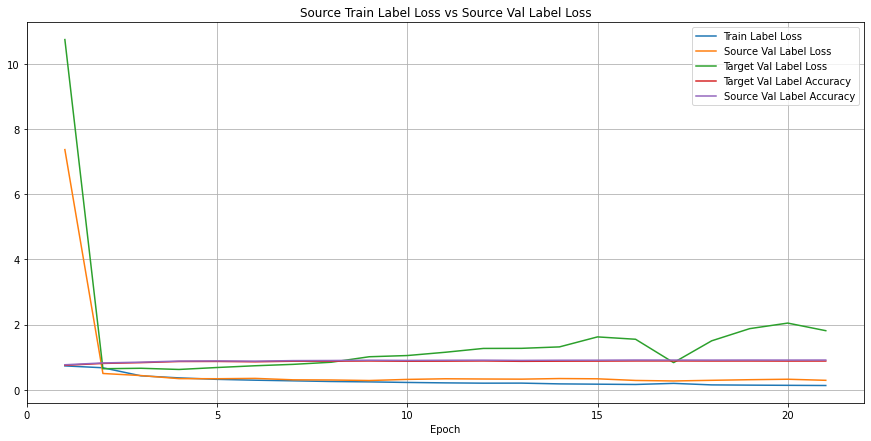

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

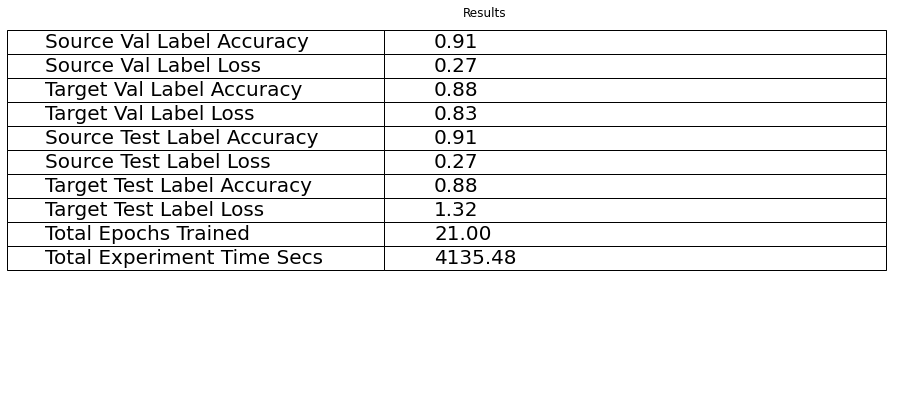

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

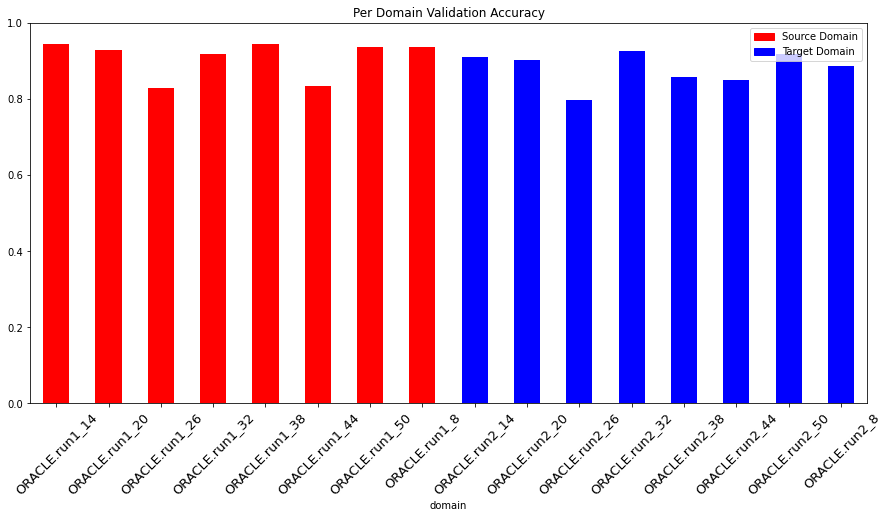

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9126627604166667 Target Test Label Accuracy: 0.87841796875
Source Val Label Accuracy: 0.90927734375 Target Val Label Accuracy: 0.8812825520833333


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed", "parameters": {"experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed", "device": "cuda", "lr": 0.0001, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 2048